In [ ]:
# Neural Network classification with pytorch

# make classification data

import sklearn
from sklearn.datasets import make_circles

In [ ]:
n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [ ]:
len(X) , len(y)

(1000, 1000)

In [ ]:
print(f'first 5 sample of X: {X[:5]}')
print(f'first 5 sample of y: {y[:5]}')

first 5 sample of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 sample of y: [1 1 1 1 0]


In [ ]:
import pandas as pd
circles = pd.DataFrame({'X1' : X[:,0],'X2' : X[:,1],'label' : y})

circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


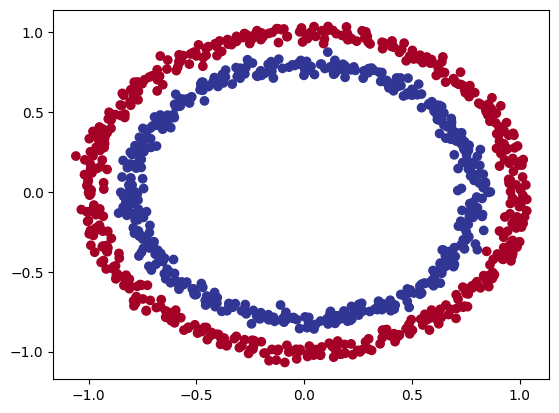

In [ ]:
# visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [ ]:
X.shape,y.shape

((1000, 2), (1000,))

In [ ]:
from sklearn.model_selection import train_test_split
import torch
torch.__version__

'2.3.1+cu121'

In [ ]:
type(X)

numpy.ndarray

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X)

torch.Tensor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

In [ ]:
#lets build model
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else 'cpu'

device

'cpu'

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=1)

    #self.two_linear_layer = nn.Sequential(
    #nn.Linear(in_features=2,out_features=10),
    #nn.Linear(in_features=10,out_features=1)
    #)

  def forward(self,x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
#lets replicated the model using nn.sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2465,  0.1808],
                      [-0.5980, -0.6131],
                      [-0.4064, -0.0712],
                      [-0.0935,  0.5394],
                      [-0.7065,  0.4049],
                      [ 0.0693,  0.2788],
                      [-0.5815, -0.5492],
                      [-0.0753,  0.5487],
                      [-0.0706, -0.0956],
                      [-0.6866,  0.2875]])),
             ('0.bias',
              tensor([-0.3779,  0.3453, -0.0515,  0.0628, -0.0894,  0.6755, -0.2446,  0.4173,
                       0.0588, -0.7007])),
             ('1.weight',
              tensor([[-0.2757,  0.0385, -0.2949, -0.0937,  0.0923, -0.1176, -0.0974, -0.3012,
                        0.3080,  0.0064]])),
             ('1.bias', tensor([-0.2495]))])

In [ ]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")

Length of predictions: 200, shape: torch.Size([200, 1])


In [ ]:
untrained_preds[:10]

tensor([[-0.5185],
        [-0.5246],
        [-0.3315],
        [-0.5722],
        [-0.0600],
        [-0.0658],
        [-0.2982],
        [-0.1900],
        [-0.3432],
        [-0.5220]])

In [ ]:
# setup loss function and optimization

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)



In [ ]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5185],
        [-0.5246],
        [-0.3315],
        [-0.5722],
        [-0.0600]])

In [ ]:
#use sigmoid on our logits to convert it into probability

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3732],
        [0.3718],
        [0.4179],
        [0.3607],
        [0.4850]])

In [ ]:
torch.round(y_pred_probs).squeeze()

tensor([0., 0., 0., 0., 0.])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Training a model
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  #forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss and accuarcy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)

  #optimizer zero grad
  optimizer.zero_grad()

  #backpropgation
  loss.backward()

  #updating params
  optimizer.step()

  #testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)

    test_acc = accuracy_fn(y_test,test_pred)

  if epoch%10==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.70897, Acc: 50.00% | Test loss: 0.70414, Test acc: 49.50%
Epoch: 10 | Loss: 0.69954, Acc: 47.00% | Test loss: 0.69652, Test acc: 46.50%
Epoch: 20 | Loss: 0.69644, Acc: 48.75% | Test loss: 0.69447, Test acc: 46.50%
Epoch: 30 | Loss: 0.69509, Acc: 49.12% | Test loss: 0.69386, Test acc: 47.00%
Epoch: 40 | Loss: 0.69435, Acc: 50.38% | Test loss: 0.69369, Test acc: 46.00%
Epoch: 50 | Loss: 0.69389, Acc: 50.12% | Test loss: 0.69367, Test acc: 46.50%
Epoch: 60 | Loss: 0.69359, Acc: 49.88% | Test loss: 0.69373, Test acc: 48.50%
Epoch: 70 | Loss: 0.69339, Acc: 49.50% | Test loss: 0.69382, Test acc: 50.00%
Epoch: 80 | Loss: 0.69326, Acc: 49.62% | Test loss: 0.69391, Test acc: 49.00%
Epoch: 90 | Loss: 0.69317, Acc: 49.50% | Test loss: 0.69401, Test acc: 48.50%


In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_function.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py','wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_function.py


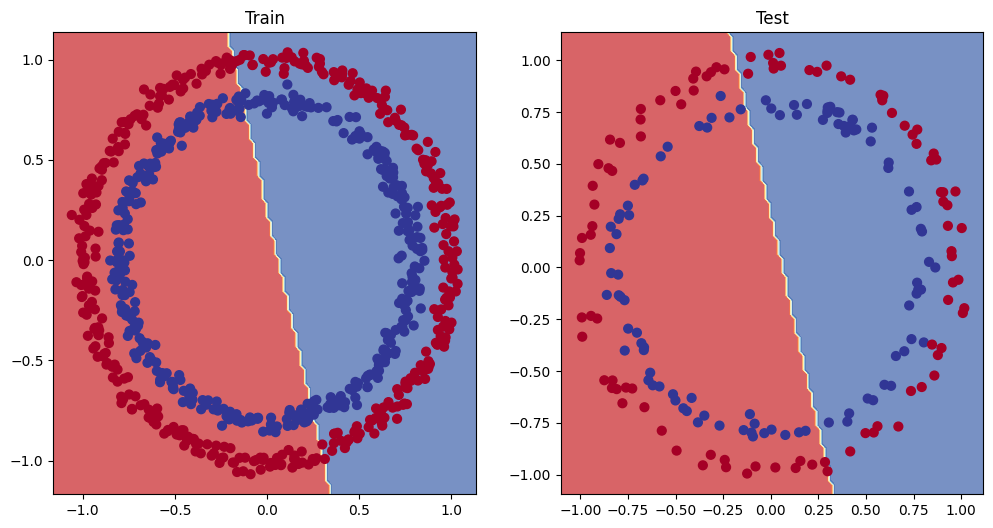

In [ ]:
# ploat decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

In [ ]:
# improving model performance
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_2(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)

    test_acc = accuracy_fn(y_test,test_pred)
  if epoch%100==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.79303, Test acc: 50.00%
Epoch: 100 | Loss: 0.69298, Acc: 51.50% | Test loss: 0.69470, Test acc: 45.50%
Epoch: 200 | Loss: 0.69317, Acc: 48.75% | Test loss: 0.69505, Test acc: 47.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


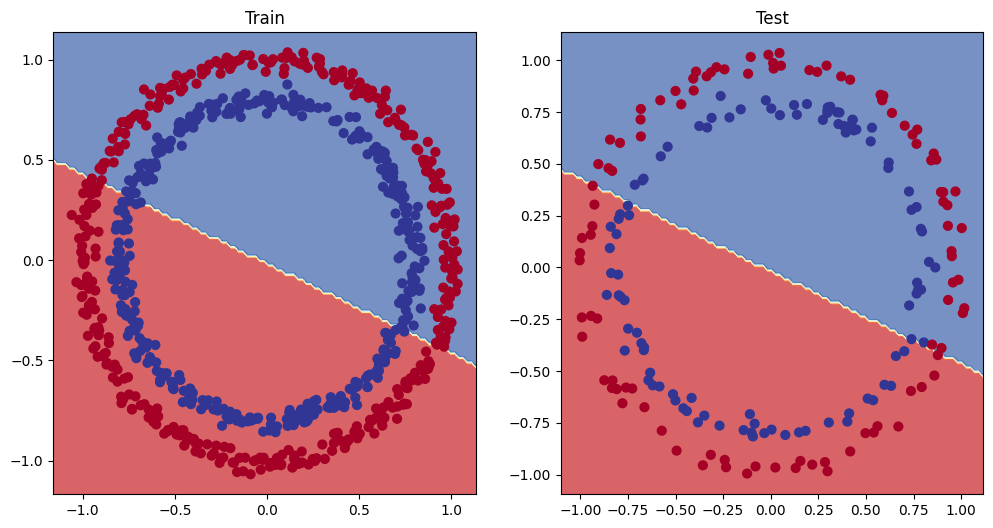

In [ ]:
# ploat decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

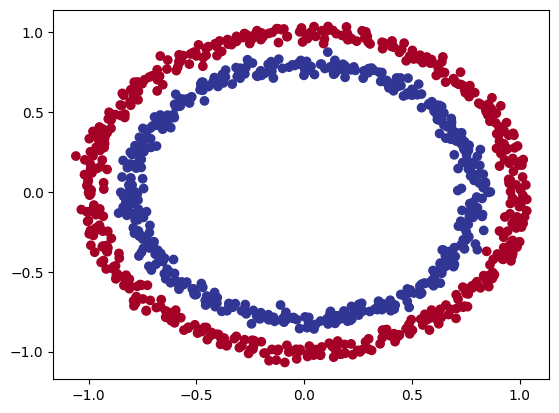

In [ ]:
# non-linearity

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,random_state=42,noise=0.03)

plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [ ]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=41)

X_train[:5], y_train[:5]

(tensor([[-0.3861, -0.9153],
         [ 0.4975, -0.7994],
         [-0.1666,  0.7994],
         [ 0.3129,  0.7756],
         [ 0.6134,  0.7296]]),
 tensor([0., 0., 1., 1., 0.]))

In [ ]:
#building the model with non-linearity

from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1= nn.Linear(in_features=2,out_features=10)
    self.layer_2= nn.Linear(in_features=10,out_features=10)
    self.layer_3= nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# define loss
loss_fn = nn.BCEWithLogitsLoss()

#define optimizer
optimizer = torch.optim.Adam(params=model_3.parameters(),lr=0.01)

In [ ]:
# writing the training loop

torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  # forward pass
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  #calculate loss and acc
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train, y_preds)

  #make zero grad
  optimizer.zero_grad()

  # backpropgation
  loss.backward()

  #update parameter
  optimizer.step()

  #testing loop
  model_3.eval()
  with torch.inference_mode():
    y_test_logits = model_3(X_test).squeeze()
    y_test_preds = torch.round(torch.sigmoid(y_test_logits))

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_test, y_test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.19275, Acc: 99.25% | Test loss: 0.18856, Test acc: 100.00%
Epoch: 10 | Loss: 0.13658, Acc: 99.62% | Test loss: 0.13105, Test acc: 100.00%
Epoch: 20 | Loss: 0.09838, Acc: 99.62% | Test loss: 0.09087, Test acc: 100.00%
Epoch: 30 | Loss: 0.07301, Acc: 99.88% | Test loss: 0.06547, Test acc: 100.00%
Epoch: 40 | Loss: 0.05579, Acc: 99.88% | Test loss: 0.04844, Test acc: 100.00%
Epoch: 50 | Loss: 0.04342, Acc: 99.88% | Test loss: 0.03955, Test acc: 100.00%
Epoch: 60 | Loss: 0.03444, Acc: 99.88% | Test loss: 0.03147, Test acc: 100.00%
Epoch: 70 | Loss: 0.02880, Acc: 99.88% | Test loss: 0.02556, Test acc: 100.00%
Epoch: 80 | Loss: 0.02468, Acc: 99.88% | Test loss: 0.02129, Test acc: 100.00%
Epoch: 90 | Loss: 0.02151, Acc: 100.00% | Test loss: 0.01831, Test acc: 100.00%


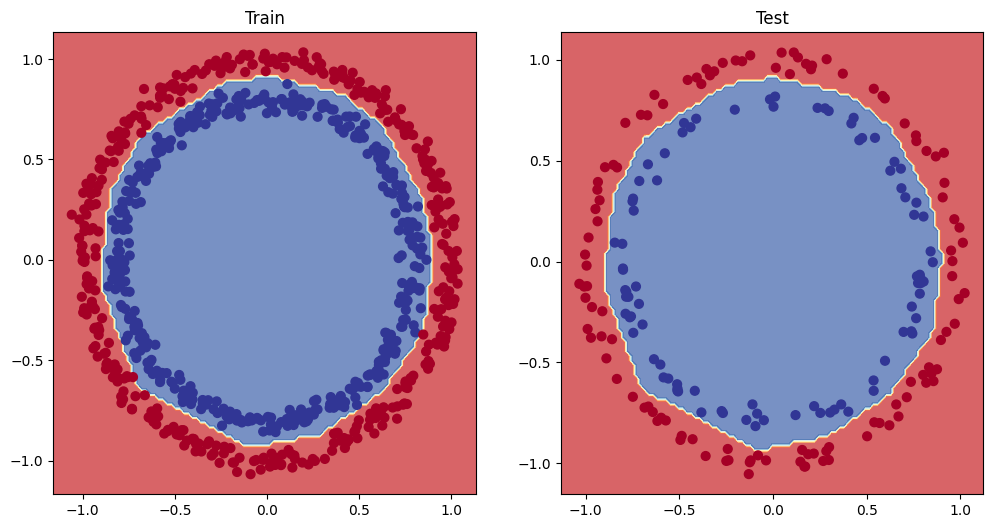

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

In [ ]:
def sigmoid(x):
  return  1/(1+ torch.exp(-x))

In [ ]:
a = torch.arange(-5,5,0.1)

In [ ]:
sigmoid_a = sigmoid(a)

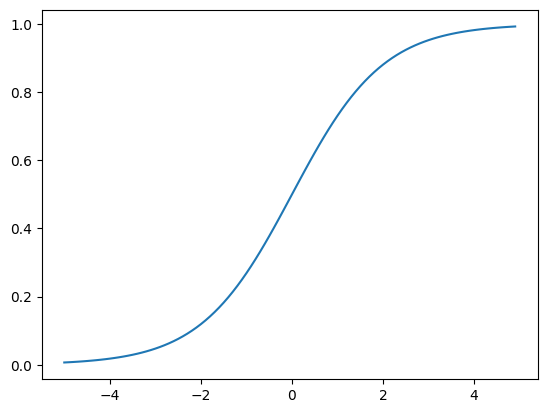

In [ ]:
plt.plot(a,torch.sigmoid(a))

Multiclass classification

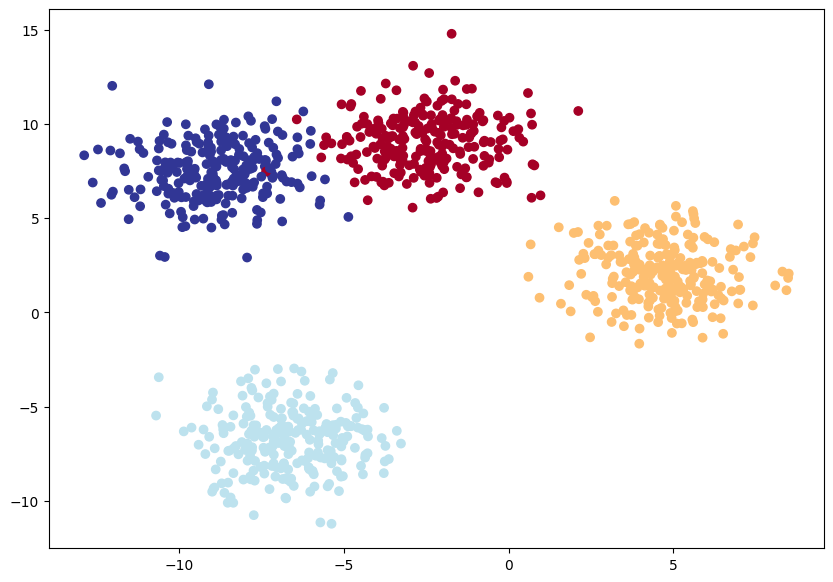

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob ,y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

#split in to train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED
)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)


In [ ]:
# buliding multiclass classification model with pytorch
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# buliding multiclass classification model with pytorch
from torch import nn
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_satck = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features))
  def forward(self, x):
    return self.linear_layer_satck(x)


model_4 = BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_satck): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [ ]:
y_blob_train[1]

tensor(0)

In [ ]:
# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params=model_4.parameters(),lr=0.01)

In [ ]:
# geting prediction probabilities
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_blob_test.to(device))[:5]

y_logits

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])

In [ ]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [ ]:
# conver our model output to prediction probability
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])

In [ ]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [ ]:
torch.max(y_pred_probs[0])

tensor(0.3244)

In [ ]:
torch.argmax(y_pred_probs[0])

tensor(1)

In [ ]:
# converting probability into labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([1, 0, 0, 0, 0])

In [ ]:
# training loop and testing loop

torch.manual_seed(42)

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

epochs = 100

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred_probs = torch.softmax(y_logits,dim=1)
  y_preds = torch.argmax(y_pred_probs,dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_blob_train,y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # teating
  model_4.eval()
  with torch.inference_mode():
    y_test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(y_test_logits,dim=1).argmax(dim=1)

    test_loss = loss_fn(y_test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test,test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.0432, Acc: 65.50% | Test Loss: 0.8458, test acc: 74.00%
Epoch: 10 | Loss: 0.1784, Acc: 98.88% | Test Loss: 0.1505, test acc: 99.50%
Epoch: 20 | Loss: 0.0554, Acc: 99.38% | Test Loss: 0.0447, test acc: 99.50%
Epoch: 30 | Loss: 0.0331, Acc: 99.25% | Test Loss: 0.0247, test acc: 99.50%
Epoch: 40 | Loss: 0.0275, Acc: 99.25% | Test Loss: 0.0174, test acc: 99.50%
Epoch: 50 | Loss: 0.0255, Acc: 99.38% | Test Loss: 0.0150, test acc: 99.50%
Epoch: 60 | Loss: 0.0246, Acc: 99.38% | Test Loss: 0.0142, test acc: 99.50%
Epoch: 70 | Loss: 0.0239, Acc: 99.50% | Test Loss: 0.0134, test acc: 99.50%
Epoch: 80 | Loss: 0.0234, Acc: 99.50% | Test Loss: 0.0127, test acc: 99.50%
Epoch: 90 | Loss: 0.0230, Acc: 99.50% | Test Loss: 0.0122, test acc: 99.50%


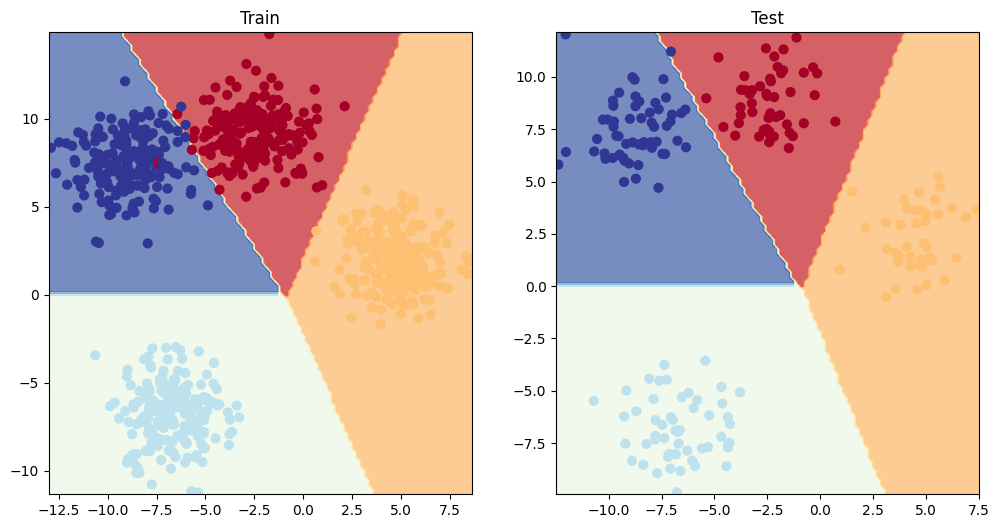

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

In [ ]:
!pip install torchmetrics


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from torchmetrics import Accuracy

acc = Accuarcy()

acc(ypres)